# TP3 : Clustering

## Imports et configuration

In [34]:
# Imports

import collections
import os
import re
import string
import sys
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import yake
from nltk import word_tokenize
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image
from IPython.display import display
nltk.download('stopwords')

import pandas as pd
from nltk.corpus import stopwords
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Config

txt_path = '../data/txt/'

temp_path = '../data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [35]:
DECADE = '1930'

files = [f for f in sorted(os.listdir(txt_path)) if f"_{DECADE[:-1]}" in f]

# Vérifier si c'est bien 1930: OK
print(files[:5])

texts = [open(txt_path + f, "r", encoding="utf-8").read() for f in files]

# Pour voir à quoi ressemble le premier document: tout est OK
print(texts[0][:400])

['KB_JB838_1930-01-05_01-00006.txt', 'KB_JB838_1930-01-09_01-00001.txt', 'KB_JB838_1930-01-09_01-00014.txt', 'KB_JB838_1930-01-16_01-00010.txt', 'KB_JB838_1930-01-20_01-00002.txt']
15 G I C 3. L ^ SQ| R V .1- . FINANCE - INDUSTRIE - COMMERCE BOURSE de BRUXELLES I Marchés d’Anvers REVUE HEBDOMADAIRE La Eourse, qui avait très peu de chance de g.tg:v»r en aciivi.é penciant cette semaine raccourcie par le congé du Nouvel- Aii, a c i cependant une attitude qui permet de bien augurer des prochaines séances. L's capitalistes semblent enfin s’être rendu compte cours leur fou: quelqu


## Vectoriser les documents à l'aide de TF-IDF

In [36]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

In [37]:
# Imprimer les détails de la matrice

tfidf_vectors

<1000x3941 sparse matrix of type '<class 'numpy.float64'>'
	with 789289 stored elements in Compressed Sparse Row format>

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

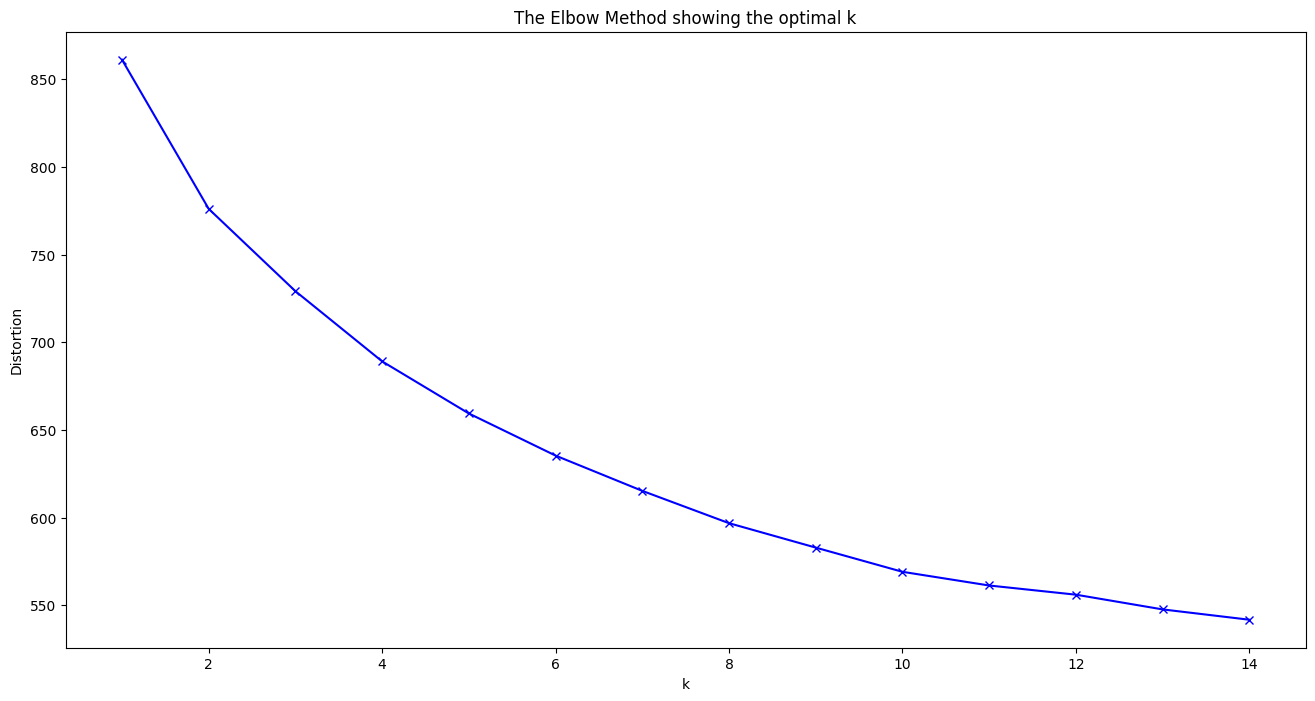

In [38]:
# Elbow method pour déterminer le nbre de clusters optimal

distortions = []
K = range(1,15) #tested:1-10, 1-15, 1-30
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [59]:
# Nbre clusters

N_CLUSTERS = 4

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [54]:
# Afficher le résultat du clustering (un dictionnaire)

dict(clustering)

{0: ['KB_JB838_1930-01-05_01-00006.txt',
  'KB_JB838_1930-01-09_01-00001.txt',
  'KB_JB838_1930-01-20_01-00002.txt',
  'KB_JB838_1930-01-30_01-00006.txt',
  'KB_JB838_1930-02-05_01-00005.txt',
  'KB_JB838_1930-03-01_01-00004.txt',
  'KB_JB838_1930-03-13_01-00003.txt',
  'KB_JB838_1930-03-21_01-00004.txt',
  'KB_JB838_1930-04-03_01-00004.txt',
  'KB_JB838_1930-04-06_01-00007.txt',
  'KB_JB838_1930-04-07_01-00003.txt',
  'KB_JB838_1930-04-14_01-00006.txt',
  'KB_JB838_1930-04-16_01-00016.txt',
  'KB_JB838_1930-05-06_01-00008.txt',
  'KB_JB838_1930-05-18_01-00011.txt',
  'KB_JB838_1930-06-16_01-00004.txt',
  'KB_JB838_1930-06-24_01-00004.txt',
  'KB_JB838_1930-07-25_01-00005.txt',
  'KB_JB838_1930-07-26_01-00006.txt',
  'KB_JB838_1930-08-05_01-00004.txt',
  'KB_JB838_1930-08-11_01-00003.txt',
  'KB_JB838_1930-08-17_01-00004.txt',
  'KB_JB838_1930-08-19_01-00003.txt',
  'KB_JB838_1930-08-20_01-00002.txt',
  'KB_JB838_1930-08-21_01-00005.txt',
  'KB_JB838_1930-08-29_01-00001.txt',
  'KB_JB8

## Visualiser les clusters

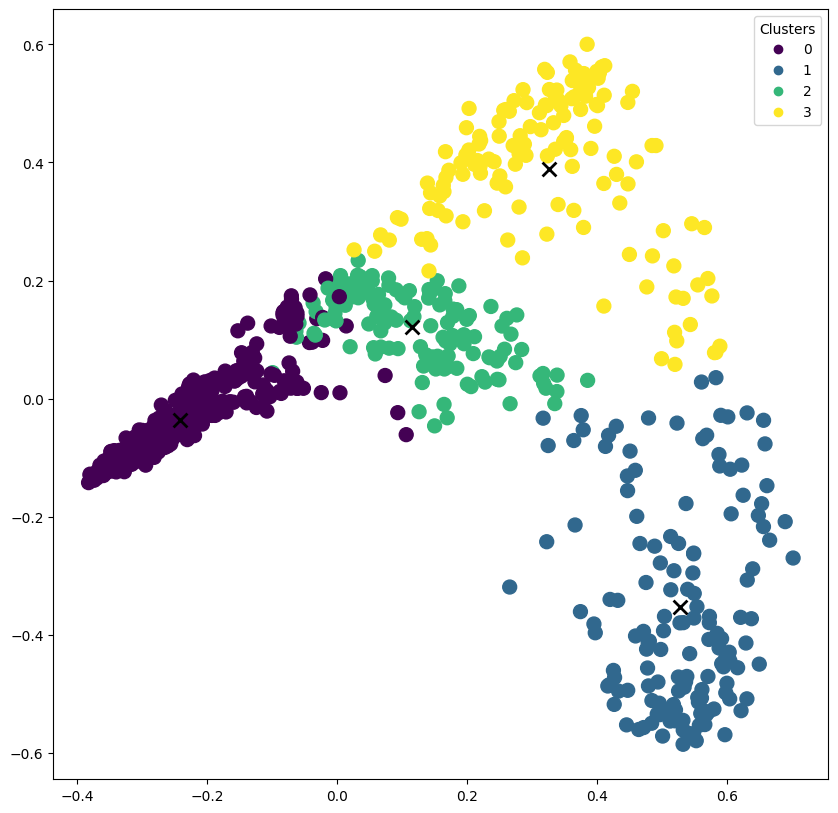

In [60]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Explorer les clusters

In [63]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(txt_path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'{DECADE}s_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

### Autour des fichiers

In [64]:
# Regarder le nombre de documents par cluster

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

Nombre de documents dans le cluster 0 : 574
Nombre de documents dans le cluster 2 : 140
Nombre de documents dans le cluster 1 : 145
Nombre de documents dans le cluster 3 : 141


Cluster n° 0, Nbre doc : 574, Counter({'1937': 67, '1939': 65, '1935': 64, '1934': 60, '1936': 60, '1938': 59, '1933': 58, '1932': 53, '1931': 46, '1930': 42})


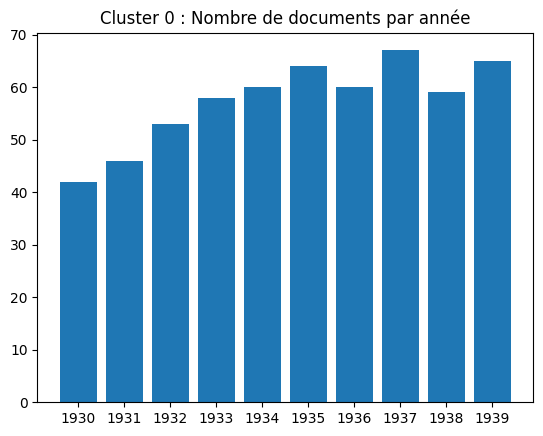

Cluster n° 2, Nbre doc : 140, Counter({'1930': 24, '1932': 18, '1931': 17, '1934': 14, '1933': 13, '1939': 13, '1937': 12, '1936': 11, '1935': 10, '1938': 8})


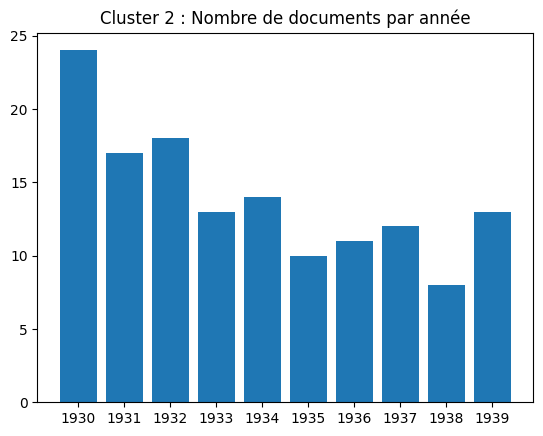

Cluster n° 1, Nbre doc : 145, Counter({'1930': 21, '1936': 21, '1938': 19, '1931': 17, '1934': 16, '1939': 13, '1935': 12, '1932': 10, '1933': 8, '1937': 8})


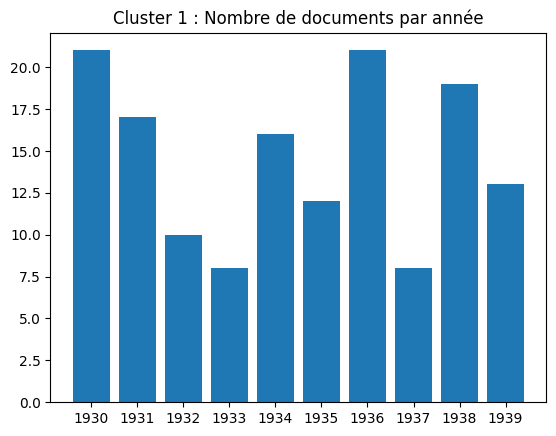

Cluster n° 3, Nbre doc : 141, Counter({'1933': 21, '1931': 20, '1932': 19, '1935': 14, '1938': 14, '1930': 13, '1937': 13, '1934': 10, '1939': 9, '1936': 8})


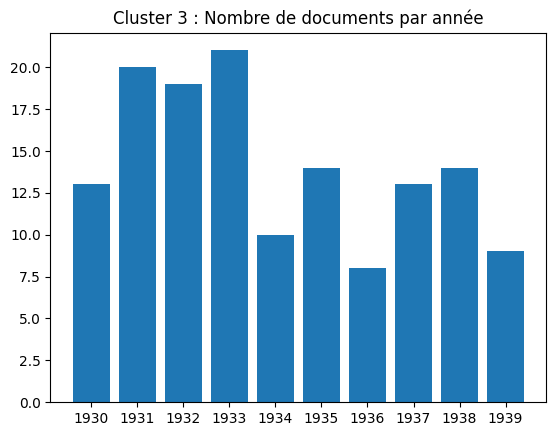

In [65]:
# Regarder la distribution des clusters selon les années

# Fonction basée autour d'une regex pour détecter l'année dans un nom de fichier
def get_year(filename):
    year = (re.search("([0-9]{4})", filename)).group()
    return year

# Création d'une liste de listes pour stocker les années pour chaque cluster
years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

# Double boucle pour ajouter l'année pour chaque cluster
for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))
    
    # testing
    # print(key, len(years_per_cluster[key]))

# testing
# print(years_per_cluster[0].count('1932'))

# Créer des graphes pour chaque cluster, en utilisant Counter pour compter le nbre de fichiers par années dans la liste de listes
for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(tmp_counter.keys(), tmp_counter.values())
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

### Keywords

4 cellules distinctes et non une boucle _for_ comme ci-dessus et ci-dessous car, pour une raison étrange, la boucle tourne "dans le vide" tandis que les cellules indépendantes donnent un résultat (après un long moment pour celle qui traite le plus gros cluster).

In [66]:
# Regarder les mots-clés de chaque cluster

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_0.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
print(f"Keywords, cluster n° 0 : {keywords}")

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2: # si c'est un bigramme
        kept_bigrams.append(kw)
    elif len(words) == 3: # si c'est un trigramme
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 0 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 0 : {kept_trigrams}")
print("")

Keywords, cluster n° 0 : [('BRUXELLES BRUXELLES BRUXELLES', 6.746625823754473e-09), ('Janvier Mars Mai', 2.6819745175844807e-07), ('BRUXELLES NAMUR BRUXELLES', 3.4112065859865237e-07), ('Mai Juin Juillet', 3.647018672549611e-07), ('Mars Mai Juillet', 4.088778940561253e-07), ('Cie Congo Belge', 4.5085727419871336e-07), ('Mai Juillet Octobre', 4.999439601958769e-07), ('BRUXELLES BONNE MAISON', 5.2308099798216e-07), ('BRUXELLES', 5.650537382902842e-07), ('Liège BRUXELLES Anver', 5.835194249846695e-07), ('Union Nautique Bruxelles', 5.963796492704636e-07), ('Juin Juillet Août', 6.128088468266632e-07), ('Bruxelles Bruxelles', 6.209410907268043e-07), ('PAUL VAN ZEELAND', 6.458479704796236e-07), ('Janvier Février Mars', 6.527369775627868e-07), ('ANVERS ANVERS ANVERS', 6.611204766347246e-07), ('Dernier cours', 6.985607467301581e-07), ('Sport Nautique Bruxelles', 7.243315027977257e-07), ('Paris Paris', 7.849174941465544e-07), ('Décembre Janvier Mars', 8.131186766964034e-07), ('Mars Avril Mai', 8

In [67]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_1.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
print(f"Keywords, cluster n° 1 : {keywords}")

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2: # si c'est un bigramme
        kept_bigrams.append(kw)
    elif len(words) == 3: # si c'est un trigramme
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 1 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 1 : {kept_trigrams}")
print("")

Keywords, cluster n° 1 : [('Ecrire Agence Rossel', 4.516279369435127e-09), ('Agence Rossel', 2.571758303508135e-08), ('Agence Rossel Bruxelles', 2.190754349930719e-07), ('Offre AGENCE ROSSEL', 4.2053458196196946e-07), ('DEMANDE Jeune fille', 4.457064104198154e-07), ('JNE FILLE dem', 4.773254053184795e-07), ('Ecr Agence Rossel', 5.334799548449977e-07), ('dem', 5.347340500270284e-07), ('Ecrire Agence', 5.477572890641006e-07), ('rue Agence Rossel', 5.593072437600813e-07), ('références Agence ROSSEL', 6.720757442608388e-07), ('JEUNE fille dem', 6.85163387628228e-07), ('DEMANDE Agence Rossel', 8.37667811045862e-07), ('prix Agence Rossel', 8.784355712664989e-07), ('Rossel', 9.315953795368965e-07), ('JNE FEMME dem', 1.0646821982088097e-06), ('demande bon ouvrier', 1.1085844665271743e-06), ('DEMANDE Jeune homme', 1.3408374585745152e-06), ('DAME seule dem', 1.5454253300092047e-06), ('JEUNE DAME DEM', 1.7131139519017098e-06), ('COIFFEUR dames dem', 1.7318165011505723e-06), ('JNE fille', 1.959895

In [68]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_2.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
print(f"Keywords, cluster n° 2 : {keywords}")

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2: # si c'est un bigramme
        kept_bigrams.append(kw)
    elif len(words) == 3: # si c'est un trigramme
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 2 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 2 : {kept_trigrams}")
print("")

Keywords, cluster n° 2 : [('Ecrire Agence Rossel', 9.146399299349418e-07), ('Agence Rossel', 1.178761888865962e-06), ('AGENCE CITROEN Rue', 3.0951412642668984e-06), ('bas prix', 3.634928177837986e-06), ('Rue', 3.690429843117879e-06), ('vendre bas prix', 5.275448309085967e-06), ('ACHAT Bons vieux', 5.735959161099734e-06), ('bon état', 6.044813165861053e-06), ('prix Agence Rossel', 6.078699745210123e-06), ('prix', 7.372906797779541e-06), ('Ouvrier vend prix', 7.989826058069062e-06), ('ACHAT Haut prix', 8.868232006181257e-06), ('HAUT PRIX Bijoux', 1.0483046785087097e-05), ('occasions BAS PRIX', 1.1123752987134339e-05), ('Rossel Agence Rossel', 1.2028744078344934e-05), ('rue Jules Van', 1.224591006754352e-05), ('Bruxelles', 1.2697516846407627e-05), ('Agence Rossel Agence', 1.3979695310983228e-05), ('vendre', 1.4044259677297756e-05), ('ROSSEL', 1.4828287740229519e-05), ('BRUXELLES BAS PRIX', 1.4965717466265894e-05), ('BAS PRIX Tél', 1.5014943427619906e-05), ('rue Royale', 1.5617646691224672

In [69]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_3.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
print(f"Keywords, cluster n° 3 : {keywords}")

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2: # si c'est un bigramme
        kept_bigrams.append(kw)
    elif len(words) == 3: # si c'est un trigramme
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 3 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 3 : {kept_trigrams}")
print("")

Keywords, cluster n° 3 : [('LOUER belle maison', 1.0062515588978884e-07), ('Ecrire Agence ROSSEL', 1.7767417511368938e-07), ('Agence RosseL', 3.132844511289106e-07), ('vendre belle maison', 3.820784545428936e-07), ('LOUER bel app', 4.114307076506618e-07), ('louer rue Royale', 5.815660152922919e-07), ('LOUER bel appart', 6.155374312847455e-07), ('LOUER BEL APPARTEMENT', 6.712262261951392e-07), ('LOUER MAISON', 7.024252065894434e-07), ('louer petite maison', 7.865051897955451e-07), ('louer jolie maison', 1.1345054013010617e-06), ('vendre Jolie maison', 1.1499316740672249e-06), ('Agence Rossel Bruxelles', 1.2213068829687556e-06), ('louer', 1.258392337405276e-06), ('louer belle villa', 1.31076249031301e-06), ('LOUER bel', 1.5681356599136188e-06), ('Belle maison', 1.60791793235298e-06), ('LOUER bel Immeuble', 1.7727891431980373e-06), ('rue', 1.8668283360748757e-06), ('LOUER BEAUX APPARTEMENTS', 1.8867374755624618e-06), ('bel app', 1.914122344147387e-06), ('rue Agence Rossel', 2.074684515792

### Nuage de mots

In [70]:
# Stopwords
sw = stopwords.words("french")
sw += [
    # Coquilles OCR pas enlevées par fonction de nettoyage
    "brux", "belg", "cond", "intér","télép", "téléph", "parf", "aven", "épous", "lntér", "poli", "référ", "culs", "serv", "trav", "pers", "conf", "sach", "conn", "cuis", "chauf", "chauff", "journ", "cherc", "flam", "exlg", "ouvr", "prop", "meub", "domest", "chaus", "préf", "angl", "inst", "repr", "jard", "chamb", "terr", "franç", "élect", "conv", "rapp", "centr", "atel", "plac", "appartem", "coch", "tranq", "pled", "compr", "schaerb", "condlt", "adres", "aujourd", "couch", "compt", "pens", "exig", "conc", "comp", "situât", "merc", "gara", "couch", "charlerol",
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"{DECADE}s_cluster_{key}.txt"
        output_path = f"{DECADE}s_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}{DECADE}s_cluster_{key}.txt"
        output_path = f"{folder}{DECADE}s_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [71]:
# Appliquer la fonction et vérifier les résultats

for key in clustering.keys():

    clean_text(key, folder=temp_path)

    with open(os.path.join(temp_path, f'{DECADE}s_cluster_{key}_clean.txt'), 'r', encoding="utf-8") as f:
        after = f.read()

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print(f"Cluster n° {key} :", frequencies.most_common(200))
    print("")

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"{DECADE}s_cluster_{key}.png"))

Cluster n° 0 : [('bruxelles', 7214), ('prix', 4785), ('heures', 4191), ('cours', 3728), ('francs', 3728), ('paris', 3432), ('grand', 3234), ('belgique', 3040), ('anvers', 3001), ('pays', 2943), ('gouvernement', 2940), ('belge', 2804), ('lieu', 2755), ('soir', 2723), ('ministre', 2673), ('maison', 2583), ('concert', 2565), ('président', 2483), ('part', 2430), ('grande', 2426), ('france', 2420), ('disques', 2410), ('londres', 2375), ('général', 2302), ('dernier', 2274), ('jour', 2269), ('mars', 2264), ('mois', 2245), ('mètres', 2221), ('premier', 2194), ('temps', 2174), ('notaire', 2045), ('juillet', 1972), ('orchestre', 1922), ('points', 1875), ('première', 1865), ('série', 1841), ('matin', 1832), ('conseil', 1803), ('musique', 1765), ('allemagne', 1760), ('guerre', 1756), ('jours', 1752), ('union', 1749), ('français', 1683), ('jean', 1679), ('politique', 1677), ('chambre', 1671), ('congo', 1664), ('société', 1650), ('liège', 1624), ('partie', 1620), ('heure', 1599), ('ordre', 1560), ('

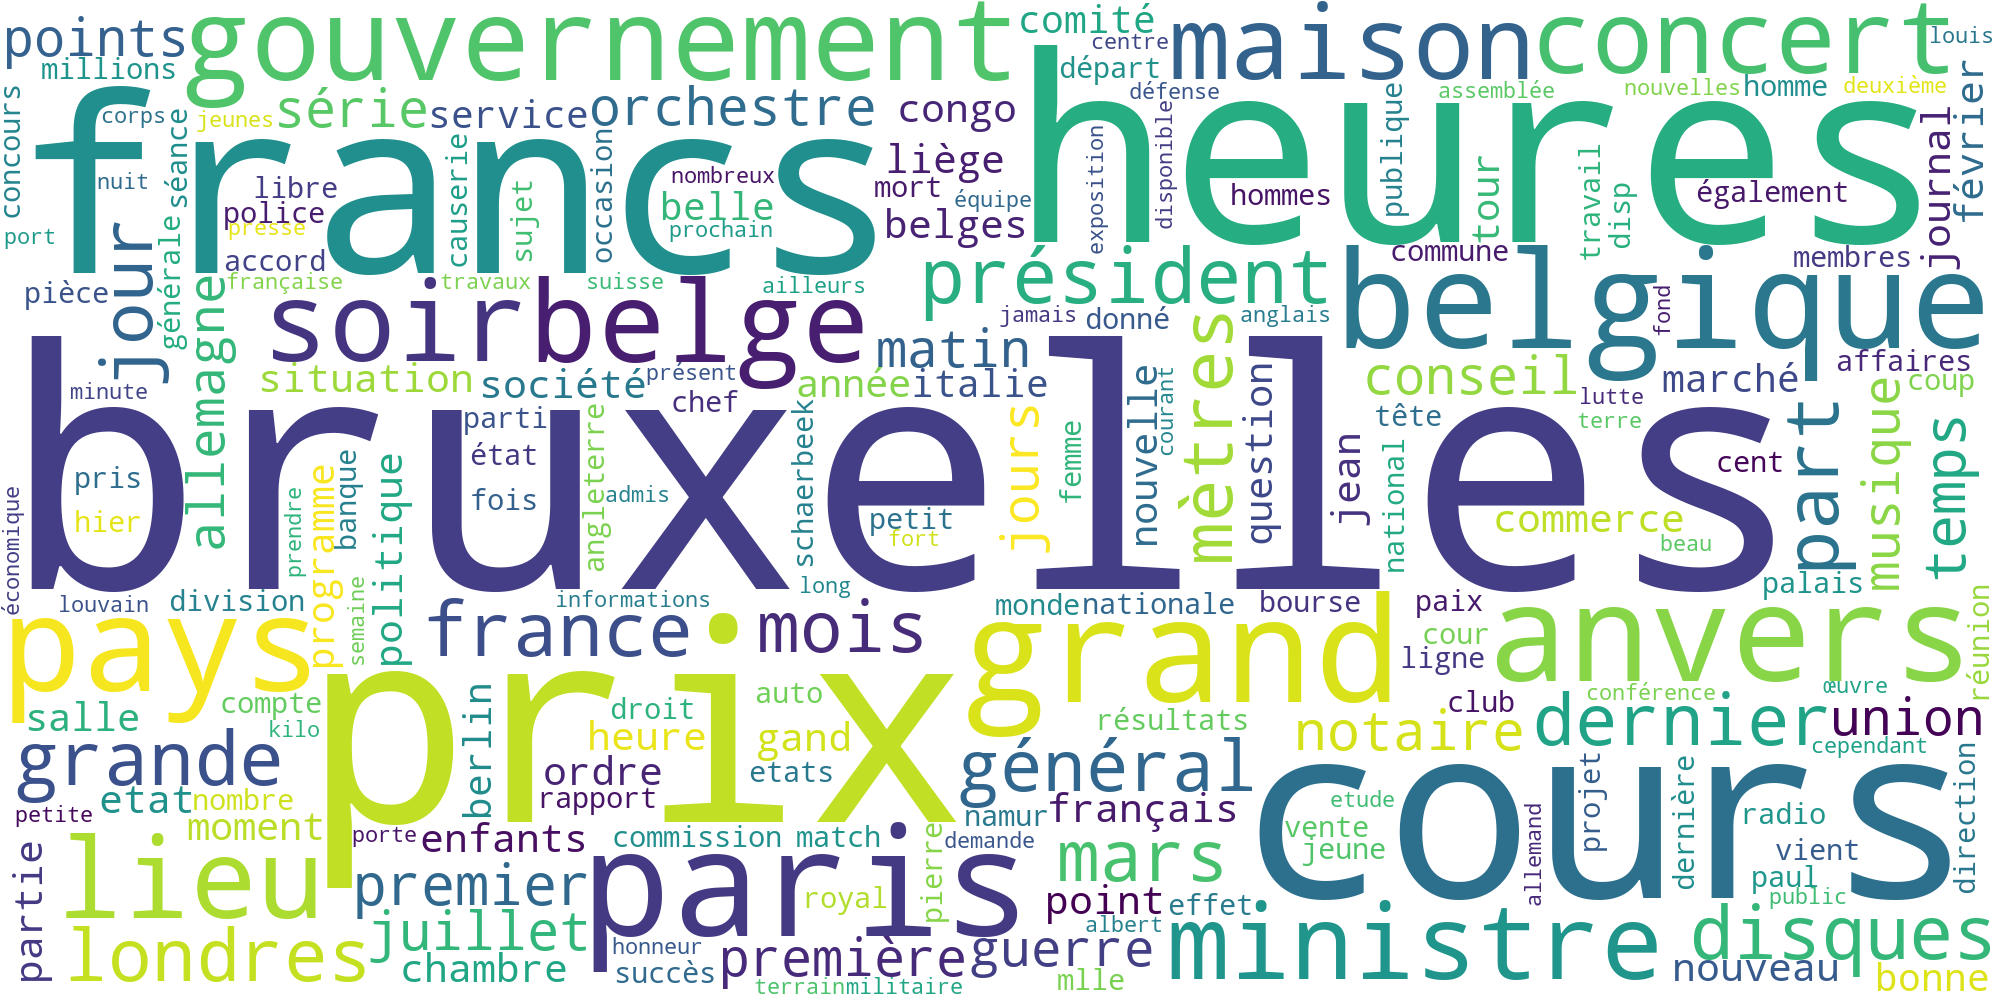

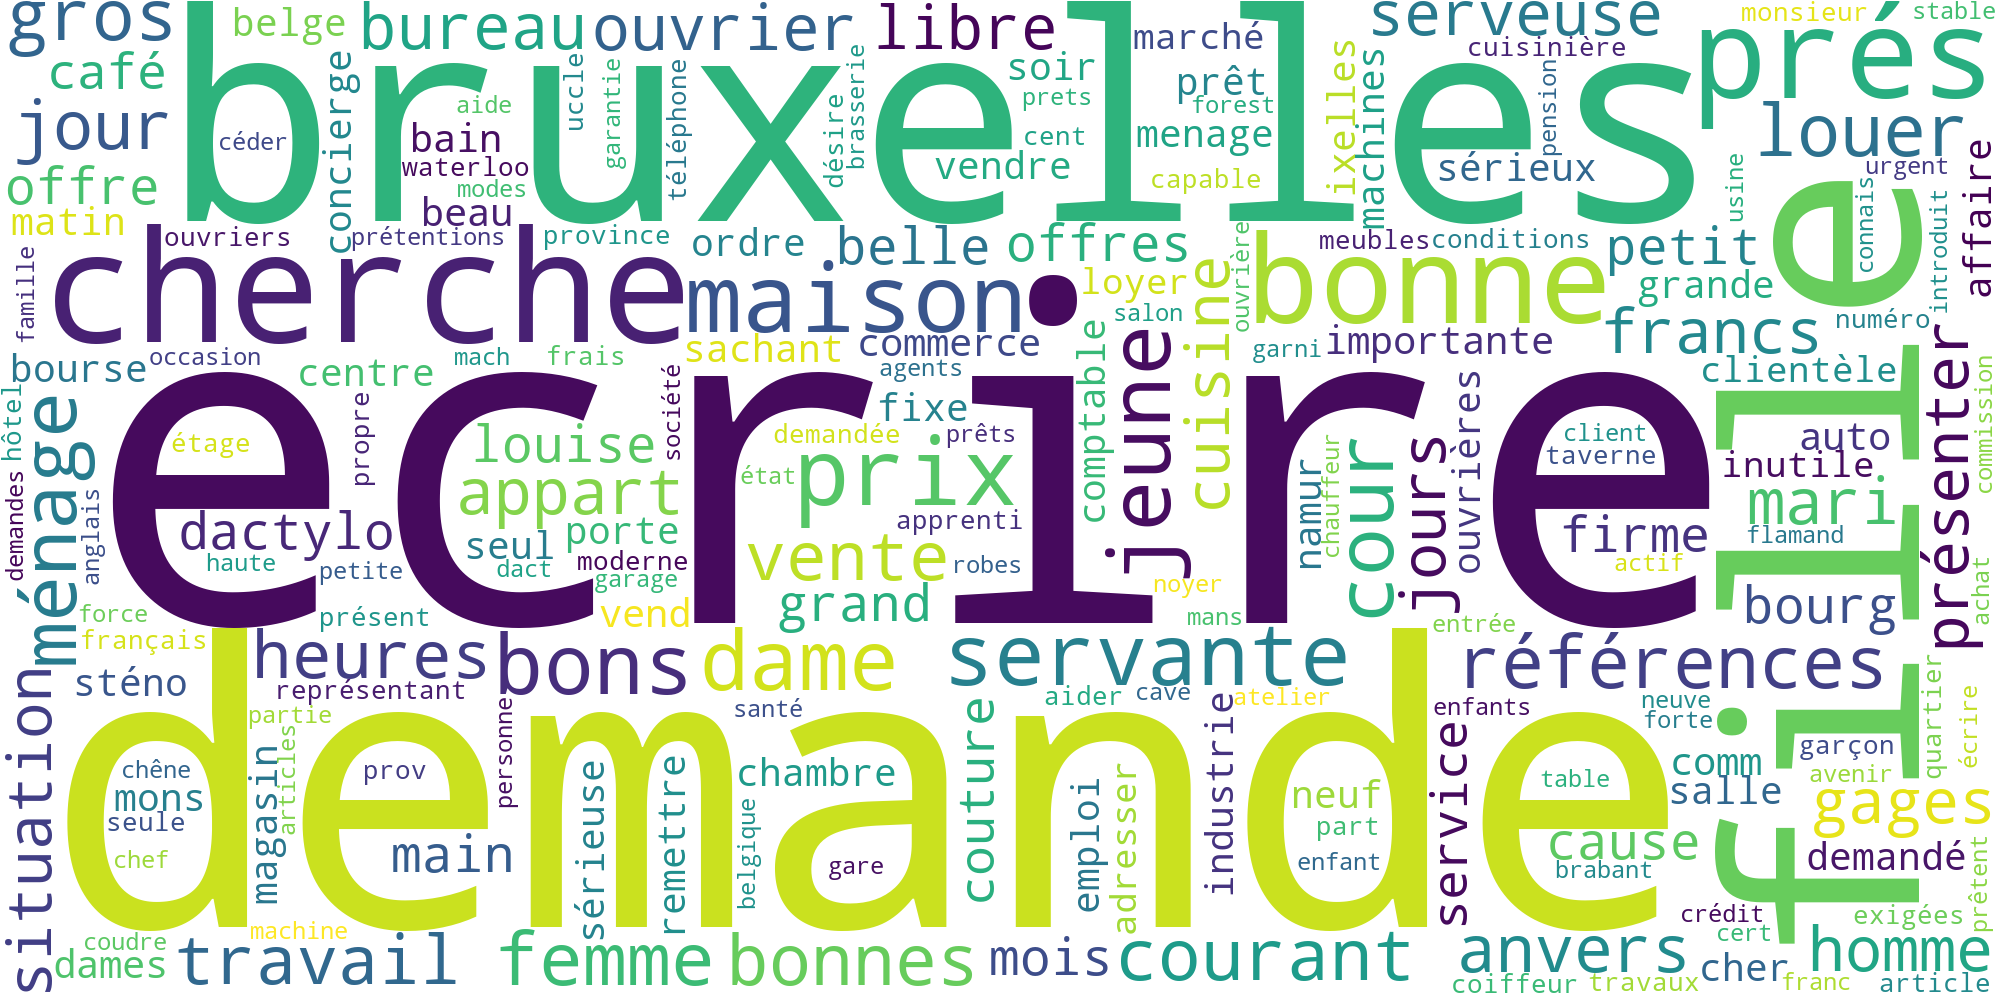

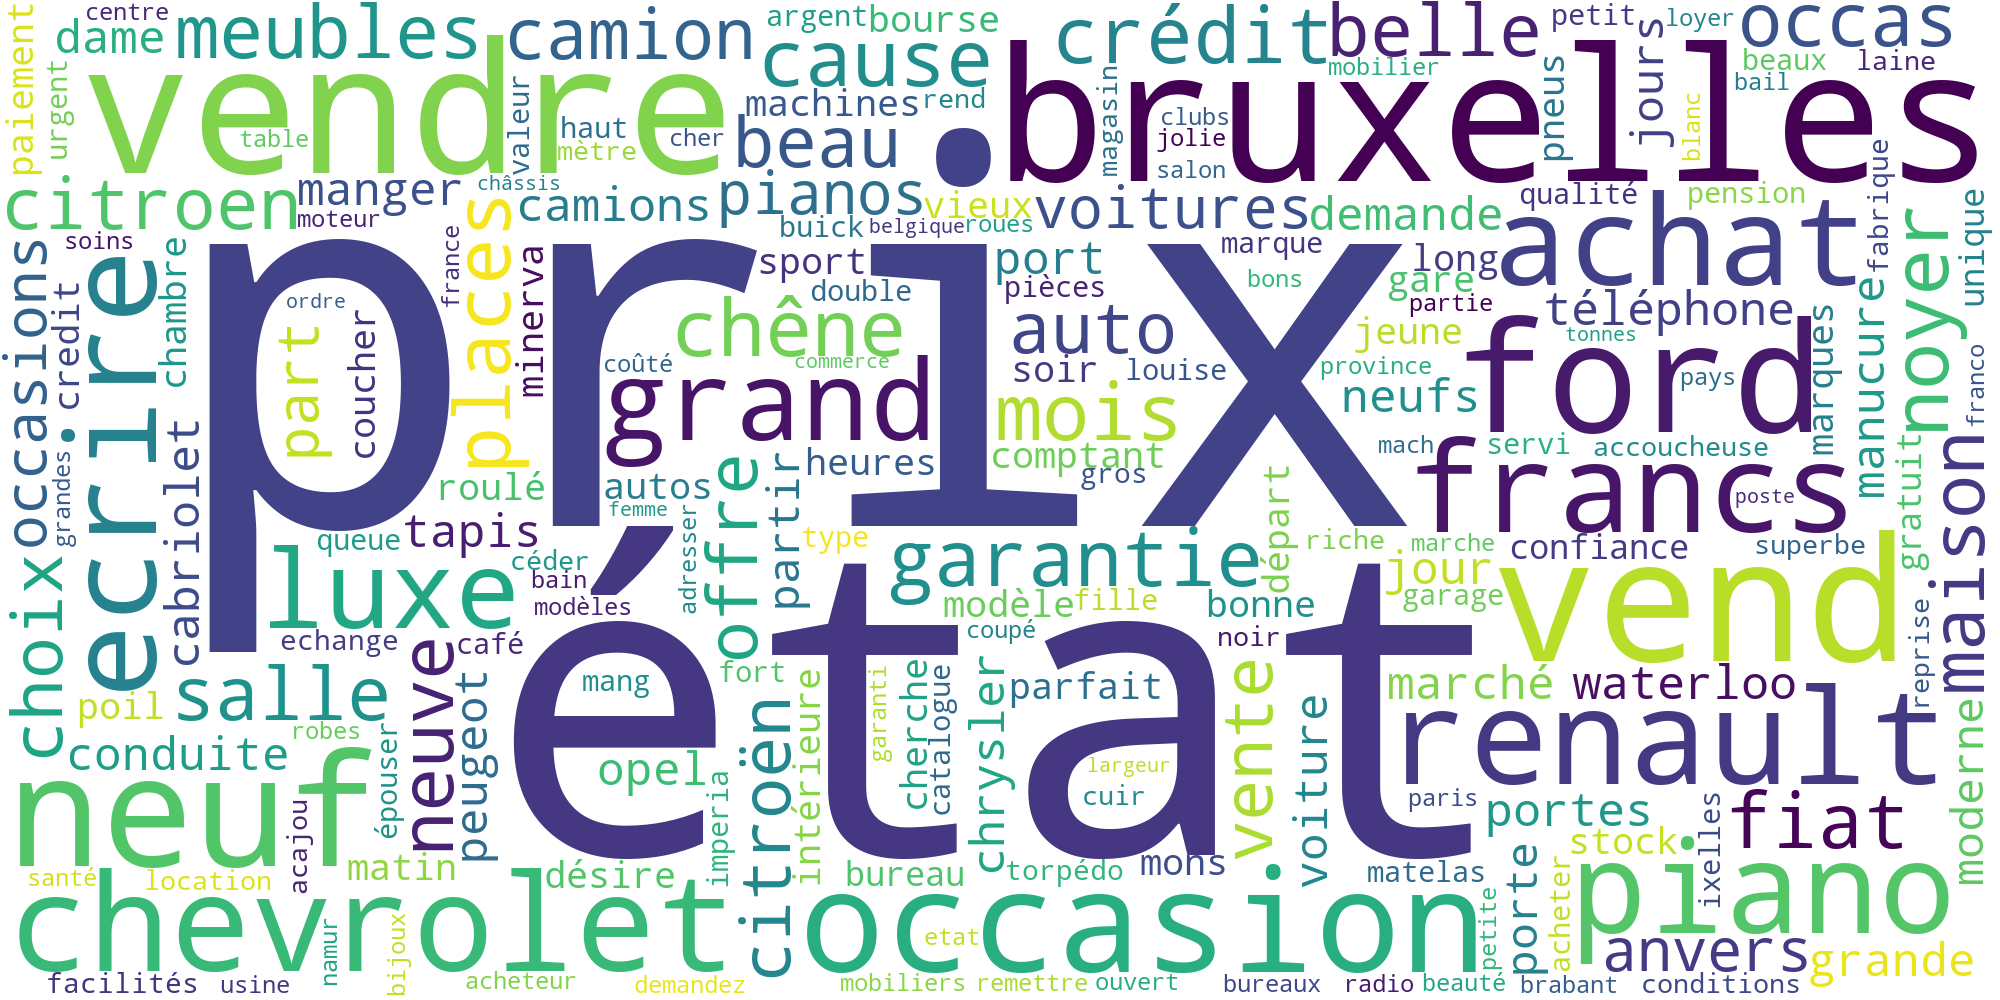

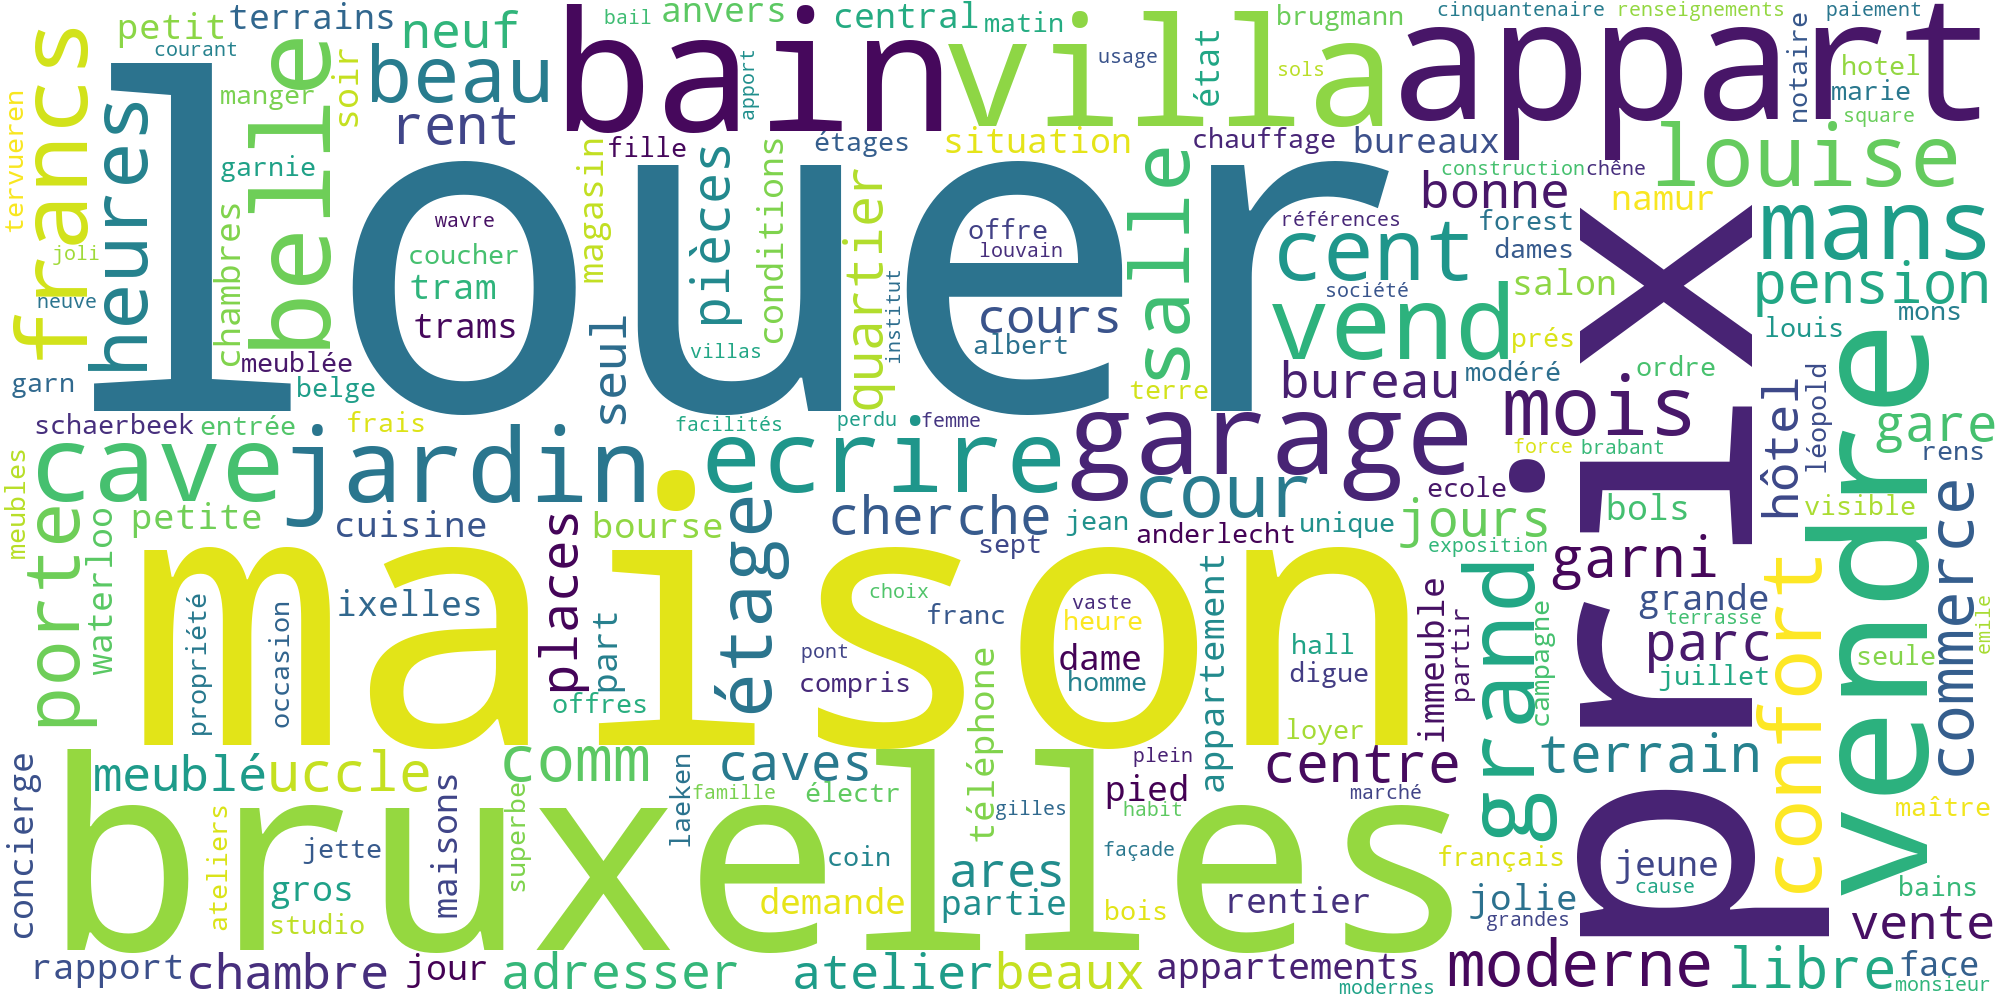

In [72]:
# Solution ad hoc car il semble impossible d'intégrer facilement plusieurs images dans une même cellule d'un jupyer notebook

w = Image(filename=f'{temp_path}1930s_cluster_0.png')
x = Image(filename=f'{temp_path}1930s_cluster_1.png') 
y = Image(filename=f'{temp_path}1930s_cluster_2.png') 
z = Image(filename=f'{temp_path}1930s_cluster_3.png')
display(w, x, y, z)